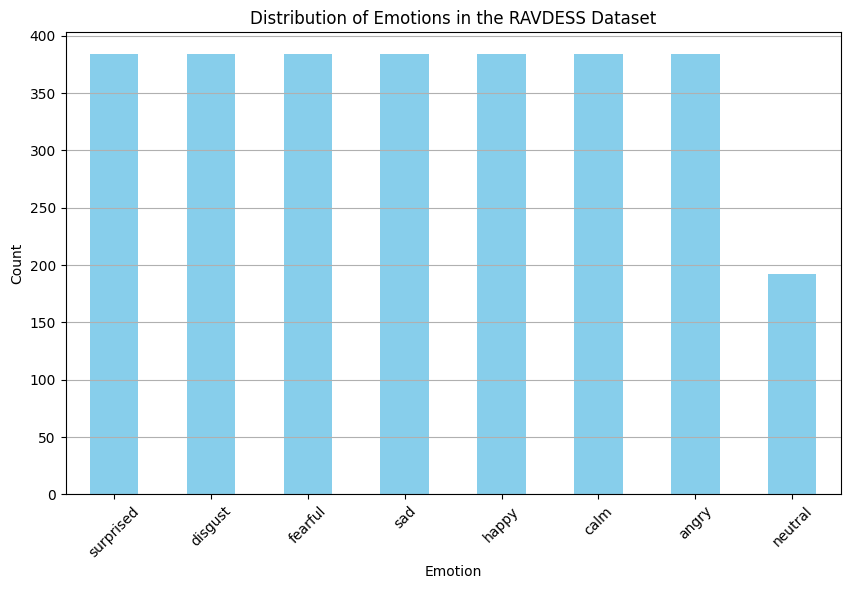

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import joblib
from joblib import Parallel, delayed
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#import streamlit as st


# Define the path to the dataset
dataset_path = "/kaggle/input/ravdess-emotional-speech-audio"

# Define a dictionary to map the emotion numbers to their labels
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Extract the labels from the filenames and create a DataFrame
def extract_emotion_labels_and_paths(dataset_path):
    file_paths = []
    emotions = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                emotion_number = file.split('-')[2]
                emotion_label = emotion_dict[emotion_number]
                file_paths.append(os.path.join(root, file))
                emotions.append(emotion_label)
    return pd.DataFrame({'File_Path': file_paths, 'Emotion': emotions})

# Get the emotion labels
df = extract_emotion_labels_and_paths(dataset_path)


# Count the occurrences of each emotion
emotion_counts = df['Emotion'].value_counts()

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions in the RAVDESS Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [32]:
#!pip install streamlit

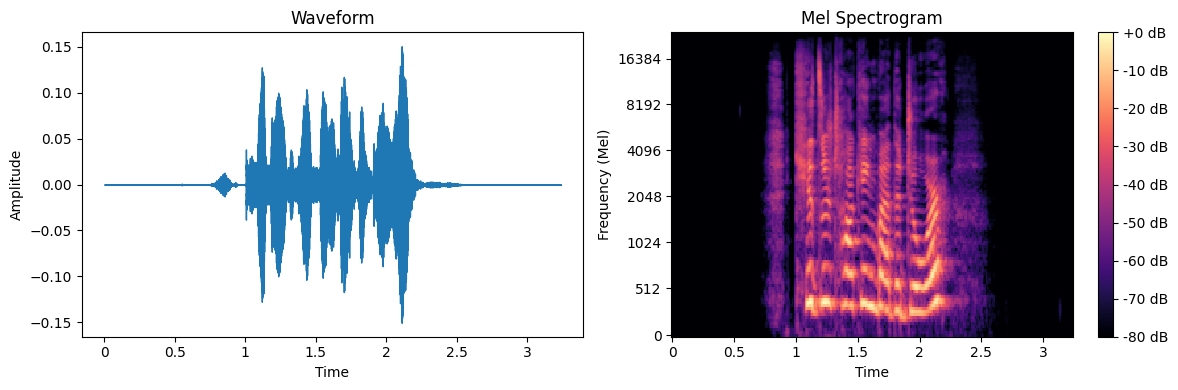

In [8]:

# Define a function to display waveform and mel spectrogram
def display_waveform_and_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot the mel spectrogram
    plt.subplot(1, 2, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Mel)')
    
    plt.tight_layout()
    plt.show()

# Example file path
example_file_path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-06-01-01-02-04.wav"

# Display the waveform and spectrogram for the example file
display_waveform_and_spectrogram(example_file_path)


In [1]:
class AudioProcessor:
    def __init__(self, ms=4000, sr=16000, n_mfcc=40):
        self.ms = ms
        self.sr = sr
        self.n_samples = int((sr / 1000) * ms)
        self.n_mfcc = n_mfcc
        #ms: Duration of the audio sample in milliseconds. Default is 4000 ms (4 seconds).
        #sr: Sampling rate for the audio. Default is 16000 Hz.
        #n_mfcc: Number of Mel-Frequency Cepstral Coefficients to extract. Default is 40.
        #n_samples: Calculates the amount of sample will be taken from each each sample rate then multiplies it with total time in seconds
        
    def load_audio(self, file_path):
        y, sr = librosa.load(file_path, sr=self.sr)
        # Pad or truncate the signal to the fixed length
        #If the audio is longer than the required number of samples, it is truncated.
        #If the audio is shorter, it is padded with zeros.
        if len(y) > self.n_samples:
            y = y[:self.n_samples]
        else:
            y = np.pad(y, (0, max(0, self.n_samples - len(y))), "constant")
        return y, sr

    def extract_mfcc(self, y):
        mfcc_features = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        #Extracts MFCC features from the audio signal using librosa.feature.mfcc.
        return mfcc_features.T.flatten()

    def add_noise(self, y, noise_factor=0.005):
        #noise_factor: The factor by which noise is scaled before being added to the audio signal. Default is 0.005.
        noise = np.random.randn(len(y))
        augmented_data = y + noise_factor * noise
        return augmented_data

    def process_feature(self, file_path, emotion):
        #processing the audio
        y, sr = self.load_audio(file_path)
        mfcc = self.extract_mfcc(y)
        return mfcc, emotion

    def process_dataset(self, df, n_jobs=-1):
        paths = df['File_Path'].values
        emotions = df['Emotion'].values

        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = [], []
        for result in results:
            X.append(result[0])
            Y.append(result[1])

        # Pad or truncate sequences to the same length
        max_len = max(len(x) for x in X)
        X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len] for x in X])

        return X, np.array(Y)


In [35]:
# Prepare the dataset
processor = AudioProcessor()
X, Y = processor.process_dataset(df)
print(type(X),type(Y))


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [36]:
print(X.shape)

(2880, 5040)


In [37]:
print(Y)

['surprised' 'neutral' 'disgust' ... 'sad' 'disgust' 'angry']


In [38]:

def prepare_dataset(X, Y, val_size=0.1, batch_size=4):
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler.pkl')

    # Encode the labels
    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)
    joblib.dump(encoder, 'label_encoder.pkl')

    num_classes = len(np.unique(Y))
    Y = to_categorical(Y, num_classes=num_classes)

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
    
    
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    print(type(X_train), type(Y_train),type(X_test),type(Y_test))

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_train_tensor = torch.tensor(np.argmax(Y_train, axis=1), dtype=torch.long)
    Y_val_tensor = torch.tensor(np.argmax(Y_val, axis=1), dtype=torch.long)
    Y_test_tensor = torch.tensor(np.argmax(Y_test, axis=1), dtype=torch.long)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, X_train_tensor, X_val_tensor, X_test_tensor, Y_train_tensor, Y_val_tensor, Y_test_tensor

# Example usage
X_train, X_val, X_test, Y_train, Y_val, Y_test, X_train_tensor,  X_val_tensor, X_test_tensor, Y_train_tensor, Y_val_tensor, Y_test_tensor = prepare_dataset(X, Y)






(1843, 5040) (1843, 8) (576, 5040) (576, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [39]:
print(X_train_tensor.shape, X_test_tensor.shape, Y_train_tensor.shape, Y_test_tensor.shape)

torch.Size([1843, 5040]) torch.Size([576, 5040]) torch.Size([1843]) torch.Size([576])


In [40]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        # Calls the constructor of the parent class (nn.Module) to initialize the module and add little adjustments.
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        weights = self.attention(x)
        # The attention weights.
        return weights

def attentive_statistical_pooling(mfccs, attention_weights):
    #Computes the weighted mean and weighted standard deviation of the input features using the attention weights.
    weighted_mean = torch.sum(attention_weights * mfccs, dim=1)  # Shape: (batch_size, input_dim)
    weighted_std = torch.sqrt(torch.sum(attention_weights * (mfccs - weighted_mean.unsqueeze(1))**2, dim=1))
    # Concatenates the weighted mean and weighted standard deviation along the specified dimension (dim=1).
    # Calculates for each inpur correspondingly
    return torch.cat((weighted_mean, weighted_std), dim=1)  # Shape: (batch_size, input_dim * 2)


In [41]:
class TDNN(nn.Module):
    def __init__(self, input_dim, output_dim, context_size, dilation):
        super(TDNN, self).__init__()
        self.conv = nn.Conv1d(input_dim, output_dim, context_size, dilation=dilation)
        #input_dim: Number of input channels/features.
        #output_dim: Number of output channels/features.
        #context_size: Size of the convolutional kernel.
        #dilation: Dilation rate for dilated convolutions.
    def forward(self, x):
        return F.relu(self.conv(x))

class CNN_TDNN_LSTM_ASP_Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN_TDNN_LSTM_ASP_Classifier, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # TDNN layers
        self.tdnn1 = TDNN(128, 512, context_size=5, dilation=1)
        self.tdnn2 = TDNN(512, 512, context_size=3, dilation=2)
        self.tdnn3 = TDNN(512, 512, context_size=3, dilation=3)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        
        # Attention layer
        self.attention = Attention(256)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)  # 256 for mean + 256 for variance
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Apply CNN layers with batch normalization
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Reshape for TDNN layers
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, height * width, -1).permute(0, 2, 1)  # Change shape to (batch_size, feature_dim, seq_len)
        
        # Apply TDNN layers
        x = self.tdnn1(x)
        x = self.tdnn2(x)
        x = self.tdnn3(x)
        
        # Prepare input for LSTM
        x = x.permute(0, 2, 1).contiguous()  # Change shape to (batch_size, seq_len, features)
        
        # Apply LSTM layer
        x, _ = self.lstm(x)
        
        # Apply Attention
        attention_weights = self.attention(x)
        x = attentive_statistical_pooling(x, attention_weights)
        
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [42]:
# Initialize the model, loss function, and optimizer
input_dim = 5040  # As per your dataset
num_classes = 8
model = CNN_TDNN_LSTM_ASP_Classifier(input_dim=input_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # learning rate


Epoch 1/80, Loss: 2.032357931137085, Val Loss: 2.0484678745269775
Epoch 2/80, Loss: 2.0083885192871094, Val Loss: 2.0223286151885986
Epoch 3/80, Loss: 1.8954429626464844, Val Loss: 2.0099198818206787
Epoch 4/80, Loss: 2.0172646045684814, Val Loss: 2.002714157104492
Epoch 5/80, Loss: 2.012575149536133, Val Loss: 1.9503422975540161
Epoch 6/80, Loss: 1.9598511457443237, Val Loss: 1.9651910066604614
Epoch 7/80, Loss: 1.9770865440368652, Val Loss: 1.8251818418502808
Epoch 8/80, Loss: 1.5270618200302124, Val Loss: 1.7329051494598389
Epoch 9/80, Loss: 1.7230042219161987, Val Loss: 1.7473448514938354
Epoch 10/80, Loss: 1.6462172269821167, Val Loss: 1.6249465942382812
Epoch 11/80, Loss: 1.5673693418502808, Val Loss: 1.4658315181732178
Epoch 12/80, Loss: 1.189720869064331, Val Loss: 1.6328744888305664
Epoch 13/80, Loss: 1.2987885475158691, Val Loss: 1.3778318166732788
Epoch 14/80, Loss: 0.9719535708427429, Val Loss: 1.3341104984283447
Epoch 15/80, Loss: 0.9635718464851379, Val Loss: 1.3911935091

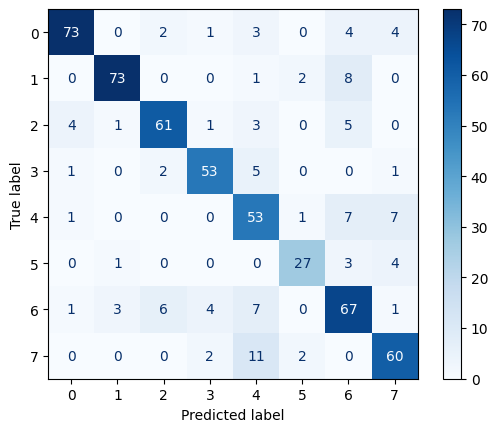

In [43]:
# Training the model with early stopping
num_epochs = 80
batch_size = 32
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    
    for i in range(0, X_train_tensor.size(0), batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], Y_train_tensor[indices]
        
        # Reshape input to (batch_size, channels, height, width)
        batch_x = batch_x.view(-1, 1, 70, 72)  # Adjust height and width to fit the convolutional layers
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_x = X_val_tensor.view(-1, 1, 70, 72)
        val_outputs = model(val_x)
        val_loss = criterion(val_outputs, Y_val_tensor).item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')
    
    # Check for early stopping
    if val_loss*0.99 < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Evaluating the model and plotting the confusion matrix
model.eval()
with torch.no_grad():
    # Reshape input to (batch_size, channels, height, width)
    X_test_tensor = X_test_tensor.view(-1, 1, 70, 72)  # Adjust height and width to fit the convolutional layers
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == Y_test_tensor).sum().item() / Y_test_tensor.size(0)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # Confusion matrix
    cm = confusion_matrix(Y_test_tensor.cpu(), predicted.cpu())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()